In [23]:
# f = open('url_addresses_hilary', 'r')
# url_addresses = f.readlines()
# test_url = url_addresses[5]
# print test_url
#with open('url_addresses_hilary','w') as f:
#     for i in links:
#         f.read(str(i['web_url'] + '\n'))

In [1]:
import pandas as pd
import requests
import numpy as np
import time
import requests
import bs4
import json
from pymongo.errors import DuplicateKeyError, CollectionInvalid, WriteError
from pymongo import MongoClient
#import datetime as dt

ImportError: cannot import name WriteError

In [4]:
client = MongoClient()
# Initiate Database
db = client['nyt_articles']
# Initiate Table
tab = db['table_hilary2']
tab.insert({'hilary': 'cool'})
#tab_trump = db['table_trump']
# tab_trump.insert({'trump': 'not cool'})

ObjectId('5601c4211f80b442510d1cb7')

In [3]:
db_comments = client['nyt_comments']

tab = db_comments['hilary_table']
#db_comments.tab.insert({'hilary': 'cool'})

tab_trump = db_comments['trump_table']
db_comments.tab_trump.insert({'hilary': 'cool'})

ObjectId('5601876c1f80b4d992902029')

### USING A PYTHON API WRAPPER FOR ARTICLE SEARCH

In [27]:
# from nytimesarticle import articleAPI
# api = articleAPI('74c73309c1052e6aa1785df7cd5cef8c:9:69947183')

In [82]:
##Articles search

# for i in range(1000):
#     articles = api.search(q = 'Hilary Clinton', page = i)
#     time.sleep(0.)
#     for y in range(len(articles['response']['docs'])):
#         new_data = articles['response']['docs'][y]
#         new_data['_id'] = articles['response']['docs'][y]['_id']
#         try:
#             db.table_hilary.insert(new_data)
#         except DuplicateKeyError:
#             print 'Peggy doesnt know why its a duplicate!! :((('

In [5]:
NYT_URL = 'http://api.nytimes.com/svc/search/v2/articlesearch.json'
API_KEY = '74c73309c1052e6aa1785df7cd5cef8c:9:69947183'

In [2]:
def single_query(link, payload):
    response = requests.get(link, params=payload)
    if response.status_code != 200:
        print 'WARNING', response.status_code
    else:
        return response.json()

In [7]:
# Query the NYT API once
def single_query(link, payload):
    response = requests.get(link, params=payload)
    if response.status_code != 200:
        print 'WARNING', response.status_code
    else:
        return response.json()

# Determine if the results are more than 100 pages
def more_than_100_pages(total_page):
    if total_page > 100:
        pages_left = min(total_page - 100, 100)
        return 100, pages_left, True
    else:
        return total_page, 0, False

# Looping through the pages give the number of pages
def loop_through_pages(total_pages, link, payload, table):
    for i in range(total_pages):
        if i % 50 == 0:
            print ' || Page ', i
        payload['page'] = str(i)
        content = single_query(link, payload)
        meta_lst = content['response']['docs']

        for meta in meta_lst:
            try:
                table.insert(meta)
            except DuplicateKeyError:
                print 'DUPS!'


# Scrape the meta data (link to article and put it into Mongo)
def scrape_meta(days=1):

    # The basic parameters for the NYT API
    link = NYT_URL
    payload = {'api-key': API_KEY, 'q' : 'Rodham Clinton'}

    today = dt.datetime(2015, 9, 22)
    yesterday = dt.datetime(2003, 9, 22)
    
    for day in range(days):
        payload['end_date'] = today.strftime("%Y%m%d")
        #yesterday = dt.date.today() - dt.timedelta(1)
        half_day = today - dt.timedelta(hours=12)
        payload['begin_date'] = yesterday.strftime("%Y%m%d")
        print payload
        print 'Scraping period: %s - %s ' % (str(yesterday), str(today))

        today -= dt.timedelta(days=2)
        
        content = single_query(link, payload)
        hits = content['response']['meta']['hits']
        total_pages = (hits / 10) + 1
        print 'HITS', hits

        newest_sort_pages, oldest_sort_pages, grt_100 = more_than_100_pages(total_pages)

        if grt_100:
            new_payload = payload.copy()
            old_payload = payload.copy()
            new_payload['sort']= 'newest'
            old_payload['sort'] = 'oldest'

        loop_through_pages(newest_sort_pages, link, new_payload, db.table_hilary2)
        loop_through_pages(oldest_sort_pages, link, old_payload, db.table_hilary2)

In [8]:
scrape_meta(days=1)

{'q': 'Rodham Clinton', 'begin_date': '20030922', 'api-key': '74c73309c1052e6aa1785df7cd5cef8c:9:69947183', 'end_date': '20150922'}
Scraping period: 2003-09-22 00:00:00 - 2015-09-22 00:00:00 
HITS 17491
 || Page  0
 || Page  50
 || Page  0
 || Page  50
DUPS!


### GRABBING ALL URLS FROM THE ARTICLES DATABASE

In [88]:
links = db.table_hilary.find({},{'web_url': 1, '_id' : 0})
links_h = []
for i in links:
    links_h.append(str(i['web_url']))
len(links_h)

1999

### QUERY COMMENTS BY EACH URL IN THE LIST

In [91]:
for url in links_h:
    print url
    link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
    payload = {'api-key': '603ff640088f24876c37e2857d83401f:1:73015248'}     
    content = single_query(link, payload)
    total = content['results']['totalCommentsFound'] 
    if total == 0:
        pass
    else:
        count = ((total/25) + 2)*25
        num_pages = list(np.arange(0, count, 25))  
            
        for i in num_pages:
            link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
            payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754', 'offset' : i}
            for y in range(len(content['results']['comments'])): 
                new_data = content['results']['comments'][y]
                new_data['web_url'] = url
                new_data['_id'] = content['results']['comments'][y]['commentID']
                try:
                    db_comments.tab.insert(new_data)
                except DuplicateKeyError:
                    print 'Peggy doesnt know why its a duplicate.'
                    pass

### EXAMPLE 

In [51]:
url = 'http://www.nytimes.com/2015/07/16/world/middleeast/obama-diplomacy-iran-nuclear-deal.html'
link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754', 'offset' : 0 }     
content = single_query(link, payload)
print len(content['results']['comments'])
print content

25
{u'debug': {u'version': 3.1}, u'status': u'OK', u'results': {u'totalParentCommentsFound': 310, u'sort': u'newest', u'totalCommentsFound': 471, u'depthLimit': 0, u'callerID': None, u'totalRecommendationsReturned': 10, u'comments': [{u'recommendedFlag': None, u'parentID': None, u'replies': [], u'commentID': 15512453, u'trusted': 0, u'userDisplayName': u'Cogito', u'createDate': u'1437099567', u'userID': 33159236, u'replyCount': 0, u'commentTitle': u'<br/>', u'status': u'approved', u'sharing': 0, u'approveDate': u'1437107733', u'userTitle': u'NULL', u'recommendations': 0, u'permID': u'15512453', u'picURL': u'http://graphics8.nytimes.com/images/apps/timespeople/none.png', u'editorsSelection': False, u'parentUserDisplayName': None, u'timespeople': 1, u'userURL': u'NULL', u'userLocation': u'State of Mind', u'depth': 1, u'commentType': u'comment', u'updateDate': u'1437107733', u'commentSequence': 15512453, u'reportAbuseFlag': None, u'commentBody': u"Obama and the Democrats need to remind th

In [72]:
len(text)

310

In [61]:
num_pages = list(np.arange(0, 471, 25)) 
print num_pages

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450]


In [74]:
x = []
for i in range(310):
    x.append(text[i]['commentBody'])

#all unique?
len(set(x)) #only 43...
#shoot..


310

In [75]:
# from collections import Counter
# dups = [k for k,v in Counter(x).items() if v>1]
# len(dups) #41
# dups

In [42]:
y = []
for i in range(475):
    if text[i]['commentID'] == 15498351:
        y.append(text[i])
len(y)

1

In [73]:
url = 'http://www.nytimes.com/2015/07/16/world/middleeast/obama-diplomacy-iran-nuclear-deal.html'
link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754'}     
content = single_query(link, payload)
total = content['results']['totalCommentsFound'] 
print total

num_pages = list(np.arange(0, total, 25))  
    
for i in num_pages:
    link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
    payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754', 'offset' : i}
    content = single_query(link, payload)
    
    if len(content['results']['comments']) != 0: 
        print len(content['results']['comments'])
        for y in range(len(content['results']['comments'])): 
            new_data = content['results']['comments'][y]
            #IDs.append(new_data['commentID'])
            text.append(new_data)
    else:
        pass
    #             new_data['web_url'] = url
    #             new_data['_id'] = content['results']['comments'][y]['commentID']
    #             try:
    #                 text.append(new_data)
    #             except DuplicateKeyError:
    #                 print 'Peggy doesnt know why its a duplicate.'
    #                 pass

471
25
25
25
25
25
25
25
25
25
25
25
25
10


In [ ]:
for url in links_h:
    link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
    payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754'}     
    content = single_query(link, payload)
    total = content['results']['totalCommentsFound'] 
    if total == 0:
        pass
    else:
        num_pages = list(np.arange(0, total, 25))  
        for i in num_pages:
            link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
            payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754', 'offset' : i}
            content = single_query(link, payload)
            
            if len(content['results']['comments']) != 0: 
                for y in range(len(content['results']['comments'])): 
                new_data = content['results']['comments'][y]
                new_data['web_url'] = url
                new_data['_id'] = content['results']['comments'][y]['commentID']
                try:
                    db_comments.tab_trump.insert(new_data)
                except DuplicateKeyError:
                    print 'Peggy doesnt know why its a duplicate.'
                    pass

In [4]:
for url in links_t:
    link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
    payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754'}     
    content = single_query(link, payload)
    total = content['results']['totalCommentsFound'] 
    if total == 0:
        pass
    else:
        count = ((total/25) + 2)*25
        num_pages = list(np.arange(0, count, 25))  
            
        for i in num_pages:
            link = "http://api.nytimes.com/svc/community/v3/user-content/url.json?url=" + url
            payload = {'api-key': '60a3f7d54baade3ed03a40bdb5f5e866:3:50984754', 'offset' : i}
            print i
            for y in range(len(content['results']['comments'])): 
                new_data = content['results']['comments'][y]
                new_data['web_url'] = url
                new_data['_id'] = content['results']['comments'][y]['commentID']
                try:
                    db_comments.tab_trump.insert(new_data)
                except DuplicateKeyError:
                    print 'Peggy doesnt know why its a duplicate.'
                    pass

###WHY ARE THERE SO MANY DUPLICATES?

In [28]:
for i in range(100):
    articles = api.search(q = 'Donald Trump', page = i)
    print articles
    for y in range(len(articles['response']['docs'])):
        new_data = articles['response']['docs'][y]
        new_data['_id'] = articles['response']['docs'][y]['_id']
        try:
            db.table_trump.insert(new_data)
        except DuplicateKeyError:
            print 'Peggy doesnt know why its a duplicate.'

In [166]:
links = db.table_trump.find({},{'web_url': 1, '_id' : 0})
links_t = []
for i in links:
    links_t.append(i['web_url'])


In [123]:
comments = list(db_comments.tab_carson.find({}, {'commentBody': 1, 'web_url': 1,  '_id':0})) #exclude ID
text = []
urls = []

# for i in range(len(comments)):
#     text.append(comments[i]['commentBody'])
for i in range(len(comments)):
    if comments[i].get('commentBody') == None:
        pass
    else:
        text.append(comments[i]['commentBody'].encode('utf-8'))
        urls.append(comments[i]['web_url'])


In [10]:
import pandas as pd
from itertools import *

df = pd.DataFrame(list(izip(text, urls)))
#df.head()
df.columns = ['Comment', 'URL']
#df.sort('Comment')
# df.to_csv('s%_comments') % 'carson'


###SENTIMENT ANALYSIS VIA ALCHEMY

In [250]:
from alchemyapi import AlchemyAPI
alchemyapi = AlchemyAPI()

In [64]:
hilary_text = []
#text = db_comments.tab.find({},{'commentBody': 1, '_id' : 0})
text = db_comments.tab.find()
count = db_comments.tab.find({}).count()

# for i in range(count):
#     myText = text[i]['commentBody'].encode('utf8')
#     hilary_text.append(myText)

### EXAMPLE OF URL WITH DUPLCATE COMMENTS

In [66]:
print df.sort('commentBody').loc[0, 'web_url'] #No comment section
print df.sort('commentBody').loc[6521, 'web_url'] #has about 280 comments

http://thecaucus.blogs.nytimes.com/2010/10/06/denial-and-speculation-follow-woodwards-hint-of-a-clinton-biden-swap/
http://www.nytimes.com/2014/05/08/us/gop-to-open-assault-on-white-house-over-irs-and-benghazi.html


##!!!!!! ~ IGNORE HERE DOWN ~ !!!!!!!!

In [12]:
with open("trump.txt", 'w') as f:
    for i in trump_text:
        f.write(i.encode('utf8')+ '\n')
        #foo.encode('utf8')


In [36]:
test = pd.Series(hilary_text)
#test1 = test.drop_duplicates(0)

In [37]:
test.to_csv("hilary_text")

In [ ]:
sentiment_t = []
score_list_t = []

text = db_comments.tab_trump.find({},{'commentBody': 1, '_id' : 0})
count = db_comments.tab_trump.find({}).count()
for i in range(count):
    myText = text[i]['commentBody']
    response = alchemyapi.sentiment("text", myText)
    sentiment_t.append(response["docSentiment"]["type"])
    if response["docSentiment"]["type"] == 'neutral':
        score_val = 0
    else:
        score_val = response["docSentiment"]["score"]
    
    score_list_t.append(score_val)


In [243]:
#Donald Trump
from itertools import *
sent = pd.DataFrame(sentiment)
sent.columns = ['Sentiment']
sent['Sentiment'].value_counts()
trump = pd.DataFrame(list(izip_longest(sentiment, score_list)))

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [251]:
sentiment_h = []
score_list_h = []

text = db_comments.tab.find({},{'commentBody': 1, '_id' : 0})
count = db_comments.tab.find({}).count()
for i in range(count):
    myText = text[i]['commentBody']
    response = alchemyapi.sentiment("text", myText)
    sentiment_h.append(response["docSentiment"]["type"])
    if response["docSentiment"]["type"] == 'neutral':
        score_val = 0
    else:
        score_val = response["docSentiment"]["score"]
    
    score_list_h.append(score_val)

In [252]:
#Hilary Clinton
sentH = pd.DataFrame(sentiment_h)
sentH.columns = ['Sentiment']
sentH['Sentiment'].value_counts()
hilary = pd.DataFrame(list(izip_longest(sentiment_h, score_list_h)))

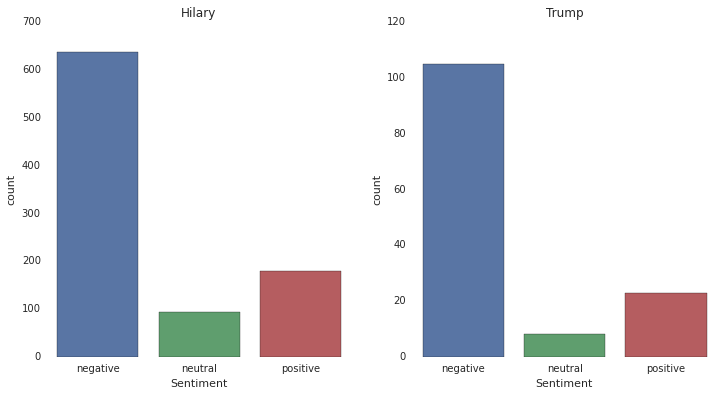

In [269]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
hilary.columns = ['Sentiment', 'Score']
hilary['Score'] = hilary['Score'].astype(float)
hilary.sort('Sentiment', inplace=True)
ax = sns.countplot(x="Sentiment", data=hilary)
plt.title('Hilary')

plt.subplot(1, 2, 2)
trump.columns = ['Sentiment', 'Score']
trump['Score'] = trump['Score'].astype(float)
trump.sort('Sentiment', inplace=True)
ax = sns.countplot(x="Sentiment", data=trump)
plt.title('Trump')

(-1.5, 1.5)

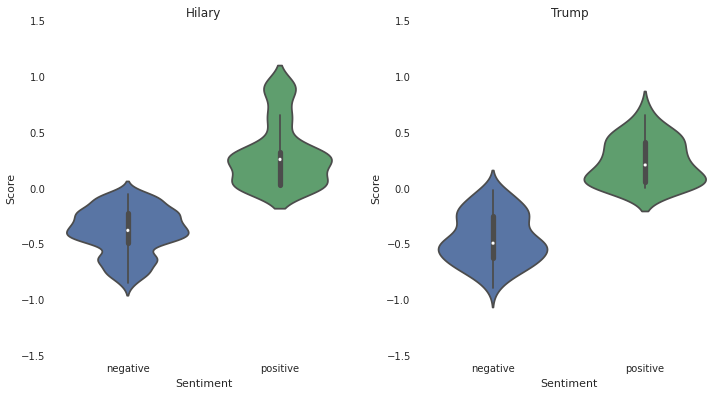

In [274]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
hilary1 = hilary[~(hilary == 0).any(axis=1)]
sns.violinplot(x="Sentiment", y='Score', data=hilary1)
plt.title('Hilary')
plt.ylim(-1.5,1.5)

plt.subplot(1, 2, 2)
trump1 = trump[~(trump == 0).any(axis=1)]
sns.violinplot(x="Sentiment", y='Score', data=trump1)
plt.title('Trump')
plt.ylim(-1.5,1.5)


###Basic sentiment classifier

In [1]:
import math
import re
#import sys
#reload(sys)
#sys.setdefaultencoding('utf-8')

# AFINN-111 is as of June 2011 the most recent version of AFINN
filenameAFINN = 'AFINN-111.txt'
afinn = dict(map(lambda (w, s): (w, int(s)), [ 
            ws.strip().split('\t') for ws in open(filenameAFINN) ]))

# Word splitter pattern
pattern_split = re.compile(r"\W+")

def sentiment(text):
    """
    Returns a float for sentiment strength based on the input text.
    Positive values are positive valence, negative value are negative valence. 
    """
    words = pattern_split.split(text.lower())
    sentiments = map(lambda word: afinn.get(word, 0), words)
    if sentiments:
        # How should you weight the individual word sentiments? 
        # You could do N, sqrt(N) or 1 for example. Here I use sqrt(N)
        sentiment = float(sum(sentiments))/math.sqrt(len(sentiments))
        
    else:
        sentiment = 0
    return sentiment


# if __name__ == '__main__':
#     # Single sentence example:
#     text = "Finn is stupid and idiotic"
#     print("%6.2f %s" % (sentiment(text), text))
    
#     # No negation and booster words handled in this approach
#     text = "Finn is only a tiny bit stupid and not idiotic"
#     print("%6.2f %s" % (sentiment(text), text))

In [2]:
text = "Finn is stupid and idiotic"
print("%6.2f %s" % (sentiment(text), text))

 -2.24 Finn is stupid and idiotic


ImportError: No module named pattern